## Importar librerias

In [58]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import logging

# Importar la librería Pandas
import pandas as pd

# Librerias utiles para trabajar con archivos
import os
import shutil

# TQDM es útil para calcular el progreso de una operación
from tqdm.auto import tqdm

# Librería para trabajar con procedimientos matematicos
import math
import random

import cv2
import math
import imageio
import seaborn as sns
from glob import glob
from pathlib import Path
from IPython.display import Image

from sklearn.model_selection import train_test_split

import seaborn as sns
import plotly.express as px
from IPython.display import SVG
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

%matplotlib inline

##Importar dataset

In [59]:
# Definir las credentiales para acceder a Kaggle
!rm -rf ~/.kaggle
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

# Puedes crear tu propio token API y nombre de usuario en la plataforma Kaggle
# deberas cambiar los siguientes datos por los de tu cuenta
api_token = {"username":"joshuanostas","key":"81ea4b87e75c75794c1ff19d6cecf318"}

import json

# Crear un archivo con las credenciales para que Kaggle pueda acceder fácilmente a él.
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [60]:
%cd /content

# Comprobar si el conjunto de datos ya se ha descargado
if not os.path.exists('./violence'):
  os.makedirs('violence')
else: 
  !rm -rf violence

# Descargar un dataset desde Kaggle
!kaggle datasets download -d mohamedmustafa/real-life-violence-situations-dataset -p violence

# Descomprimir dataset 
!unzip -qn '/content/violence/real-life-violence-situations-dataset.zip' -d /content/violence > /dev/null
!rm /content/violence/real-life-violence-situations-dataset.zip

/content
100% 3.58G/3.58G [00:29<00:00, 130MB/s]
100% 3.58G/3.58G [00:29<00:00, 129MB/s]


## Preparar Dataset

In [61]:
Main_Video_Path = Path("/content/violence/Real Life Violence Dataset")
Video_Path = list(Main_Video_Path.glob(r"*/*.mp4"))
Video_Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],Video_Path))
Video_Path_Series = pd.Series(Video_Path,name="MP4").astype(str)
Video_Labels_Series = pd.Series(Video_Labels,name="CATEGORY")
Main_MP4_Data = pd.concat([Video_Path_Series,Video_Labels_Series],axis=1)

In [62]:
Violence_Data = Main_MP4_Data[Main_MP4_Data["CATEGORY"] == "Violence"]
NonViolence_Data = Main_MP4_Data[Main_MP4_Data["CATEGORY"] == "NonViolence"]

Violence_Data = Violence_Data.reset_index()
NonViolence_Data = NonViolence_Data.reset_index()

In [63]:
Cdata = NonViolence_Data
Cdata = Cdata.append(Violence_Data,ignore_index=True, sort=False)
Cdata["CATEGORY"].replace({'Violence':1,'NonViolence':0}, inplace=True)
Cdata

,index,MP4,CATEGORY
0,1000,/content/violence/Real Life Violence Dataset/N...,0
1,1001,/content/violence/Real Life Violence Dataset/N...,0
2,1002,/content/violence/Real Life Violence Dataset/N...,0
3,1003,/content/violence/Real Life Violence Dataset/N...,0
4,1004,/content/violence/Real Life Violence Dataset/N...,0
...,...,...,...
1946,995,/content/violence/Real Life Violence Dataset/V...,1
1947,996,/content/violence/Real Life Violence Dataset/V...,1
1948,997,/content/violence/Real Life Violence Dataset/V...,1
1949,998,/content/violence/Real Life Violence Dataset/V...,1


In [64]:
! mkdir ./Frames
!cd ./Frames; mkdir ./violence; mkdir ./nonviolence

mkdir: cannot create directory ‘./Frames’: File exists
mkdir: cannot create directory ‘./violence’: File exists
mkdir: cannot create directory ‘./nonviolence’: File exists


In [65]:
violence_frame_list = []
v = 0
for file_video in Violence_Data.MP4:
    Video_File_Path = file_video
    
    Video_Caption = cv2.VideoCapture(Video_File_Path)
    Frame_Rate = 15
    count = 0
    temp = []
    while Video_Caption.isOpened():
        
        Current_Frame_ID = Video_Caption.get(1)
        
        ret,frame = Video_Caption.read()
        
        if ret != True:
            break
            
        if Current_Frame_ID % math.floor(Frame_Rate) == 0:
            image = cv2.resize(frame,(256,256))
            cv2.imwrite("./Frames/violence/frame{}{}.jpg".format(v,count), image)
            violence_frame_list.append(["frame{}{}.jpg".format(v,count),1])
            count += 1
    v += 1
        
    Video_Caption.release()
    
len(violence_frame_list)

11089

In [66]:
non_violence_frame_list = []
v = 0
for file_video in NonViolence_Data.MP4:
    Video_File_Path = file_video
    
    Video_Caption = cv2.VideoCapture(Video_File_Path)
    Frame_Rate = 10
    count = 0
    while Video_Caption.isOpened():
        
        Current_Frame_ID = Video_Caption.get(1)
        
        ret,frame = Video_Caption.read()
        
        if ret != True:
            break
            
        if Current_Frame_ID % math.floor(Frame_Rate) == 0:
            image = cv2.resize(frame,(256,256))
            cv2.imwrite("./Frames/nonviolence/frame{}{}.jpg".format(v,count), image)
            non_violence_frame_list.append(["frame{}{}.jpg".format(v,count),0])
            count += 1
    v += 1
    Video_Caption.release()
    
len(non_violence_frame_list)

12503

## Importar modelos

In [67]:
inception = tf.keras.applications.inception_v3.InceptionV3(
    include_top=False,
    input_shape=(224,224,3),
    weights='imagenet')

vgg_16 = tf.keras.applications.VGG16(
    include_top=False,
    input_shape=(224,224,3),
    weights='imagenet')

mobileNet = tf.keras.applications.MobileNetV2(
    include_top=False,
    input_shape=(224,224,3),
    weights='imagenet')

resNet = tf.keras.applications.ResNet101V2(
    include_top=False,
    input_shape=(224,224,3),
    weights='imagenet')

##Crear Modelo

In [68]:
def create_model(modelToUse):
    model = tf.keras.models.Sequential([
        modelToUse,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(2048, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(2048, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(2048, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1 , activation = 'sigmoid')
    ])
    model.layers[0].trainable = False
    return model

In [69]:
model_inception = create_model(inception)
model_inception.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2048)              4196352   
                                                                 
 batch_normalization_94 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 2048)              4

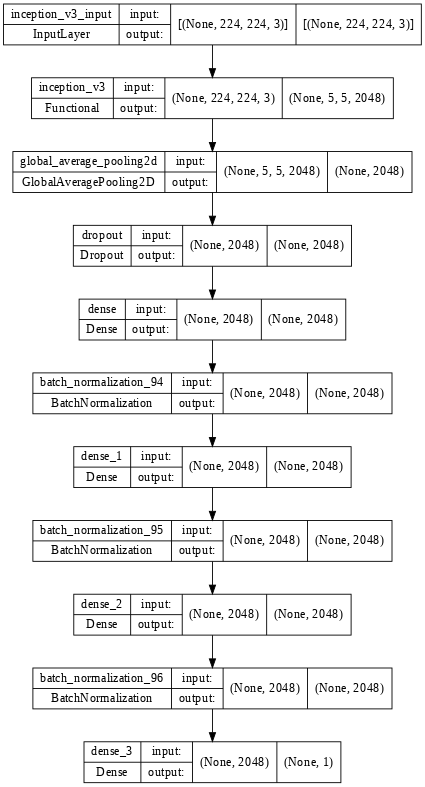

In [70]:
tf.keras.utils.plot_model(model_inception, show_shapes=True, dpi=64)

In [71]:
model_vgg_16 = create_model(vgg_16)
model_vgg_16.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 2048)              1050624   
                                                                 
 batch_normalization_97 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dense_5 (Dense)             (None, 2048)             

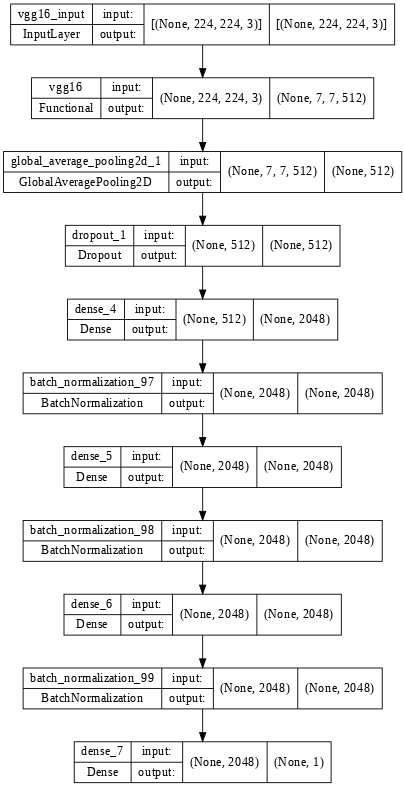

In [72]:
tf.keras.utils.plot_model(model_vgg_16, show_shapes=True, dpi=64)

In [73]:
model_mobileNet = create_model(mobileNet)
model_mobileNet.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_8 (Dense)             (None, 2048)              2623488   
                                                                 
 batch_normalization_100 (Ba  (None, 2048)             8192      
 tchNormalization)                                               
                                                      

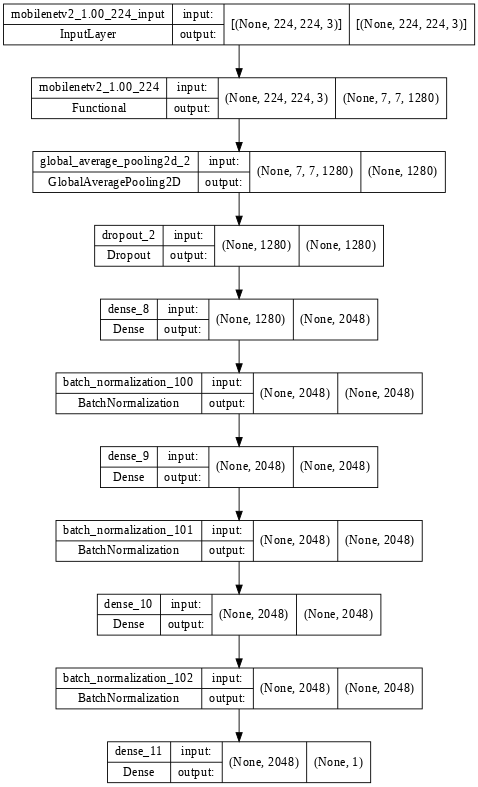

In [74]:
tf.keras.utils.plot_model(model_mobileNet, show_shapes=True, dpi=64)

In [75]:
model_resNet = create_model(resNet)
model_resNet.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101v2 (Functional)    (None, 7, 7, 2048)        42626560  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 dense_12 (Dense)            (None, 2048)              4196352   
                                                                 
 batch_normalization_103 (Ba  (None, 2048)             8192      
 tchNormalization)                                               
                                                                 
 dense_13 (Dense)            (None, 2048)             

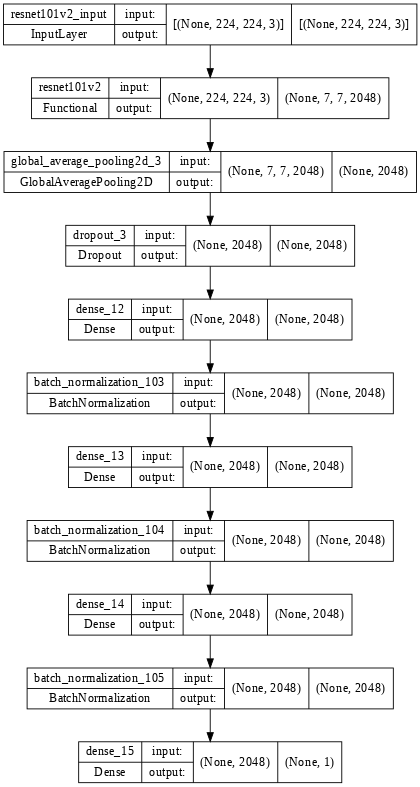

In [76]:
tf.keras.utils.plot_model(model_resNet, show_shapes=True, dpi=64)

In [77]:
def recall_m(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+tf.keras.backend.epsilon()))

##Inicializar modelos y compilarlos

In [78]:
# Inicializar los pesos y bias en el modelo
model_inception.build((None, 224, 224, 3))
model_vgg_16.build((None, 224, 224, 3))
model_mobileNet.build((None, 224, 224, 3))
model_resNet.build((None, 224, 224, 3))

# Limpiar los datos que hubiesen sido guardados en entrenamientos anteriores
tf.keras.backend.clear_session()

model_inception.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', f1_m])
model_vgg_16.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', f1_m])
model_mobileNet.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', f1_m])
model_resNet.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', f1_m])

##Crear datasets

In [79]:
inception_datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.2, 
                             rescale=1./255,
                             preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)
vgg_16_datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.2, 
                             rescale=1./255,
                             preprocessing_function=tf.keras.applications.vgg16.preprocess_input)
mobileNet_datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.2, 
                             rescale=1./255,
                             preprocessing_function=tf.keras.applications.mobilenet.preprocess_input )
resNet_datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.2, 
                             rescale=1./255,
                             preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input)

In [80]:
inception_train = inception_datagen.flow_from_directory("./Frames",
                                              target_size=(224, 224), color_mode='rgb',
                                              class_mode='binary',shuffle=True, batch_size=32,subset="training" )
inception_valid = inception_datagen.flow_from_directory("./Frames",
                                              target_size=(224, 224), color_mode='rgb',
                                              class_mode='binary',shuffle=True, batch_size=8,subset="validation")
vgg_16_train = vgg_16_datagen.flow_from_directory("./Frames",
                                              target_size=(224, 224), color_mode='rgb',
                                              class_mode='binary',shuffle=True, batch_size=32,subset="training" )
vgg_16_valid = vgg_16_datagen.flow_from_directory("./Frames",
                                              target_size=(224, 224), color_mode='rgb',
                                              class_mode='binary',shuffle=True, batch_size=8,subset="validation")
mobileNet_train = mobileNet_datagen.flow_from_directory("./Frames",
                                              target_size=(224, 224), color_mode='rgb',
                                              class_mode='binary',shuffle=True, batch_size=32,subset="training" )
mobileNet_valid = mobileNet_datagen.flow_from_directory("./Frames",
                                              target_size=(224, 224), color_mode='rgb',
                                              class_mode='binary',shuffle=True, batch_size=8,subset="validation")
resNet_train = resNet_datagen.flow_from_directory("./Frames",
                                              target_size=(224, 224), color_mode='rgb',
                                              class_mode='binary',shuffle=True, batch_size=32,subset="training" )
resNet_valid = resNet_datagen.flow_from_directory("./Frames",
                                              target_size=(224, 224), color_mode='rgb',
                                              class_mode='binary',shuffle=True, batch_size=8,subset="validation")

Found 18586 images belonging to 2 classes.
Found 4646 images belonging to 2 classes.
Found 18586 images belonging to 2 classes.
Found 4646 images belonging to 2 classes.
Found 18586 images belonging to 2 classes.
Found 4646 images belonging to 2 classes.
Found 18586 images belonging to 2 classes.
Found 4646 images belonging to 2 classes.


##Entrenar modelos

In [ ]:
Inception_EPOCHS = 7

inception_history = model_inception.fit(inception_train,
                    validation_data=inception_valid,
                    epochs = Inception_EPOCHS)

Epoch 1/7
 93/581 [===>..........................] - ETA: 31:30 - loss: 0.4907 - accuracy: 0.7554 - f1_m: 0.7284

In [ ]:
model_inception.save("./inceptionv3.hdf5")

In [ ]:
Vgg_16_EPOCHS = 5

vgg_16_history = model_vgg_16.fit(vgg_16_train,
                    validation_data=vgg_16_valid,
                    epochs = Vgg_16_EPOCHS)

In [ ]:
model_vgg_16.save("./vgg_16.hdf5")

In [ ]:
MobileNet_EPOCHS = 5

mobileNet_history = model_mobileNet.fit(mobileNet_train,
                    validation_data=mobileNet_valid,
                    epochs = MobileNet_EPOCHS)

In [ ]:
model_mobileNet.save("./mobileNet.hdf5")

In [ ]:
ResNet_EPOCHS = 5

resNet_history = model_resNet.fit(resNet_train,
                    validation_data=resNet_valid,
                    epochs = ResNet_EPOCHS)

In [ ]:
model_resNet.save("./resNet.hdf5")

In [85]:
def plot_loss_accuracy_curves(history):
  loss = history.history['loss']

  accuracy = history.history['accuracy']
  f1_score = history.history['f1_m']

  epochs = range(len(history.history['loss']))

  # Graficar perdida (Loss)
  plt.plot(epochs, loss, label='training_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Graficar presición (accuracy)
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

  # Graficar presición (f1 score)
  plt.figure()
  plt.plot(epochs, f1_score, label='training_accuracy')
  plt.title('F1 Score')
  plt.xlabel('Epochs')
  plt.legend()

In [ ]:
plot_loss_accuracy_curves(inception_history)

In [ ]:
plot_loss_accuracy_curves(vgg_16_history)

In [ ]:
plot_loss_accuracy_curves(mobileNet_history)

In [ ]:
plot_loss_accuracy_curves(resNet_history)